In [1]:
#https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g7JwwC7-pgreQTdGsGLRkc0Mxg1ksrBMPdKCpt4qfnNg36AdAH9lLQ
Mounted at /content/drive


In [ ]:
!pip install beautifulsoup4 #scraping web data
!pip install investpy #finance information
!pip install yfinance #finance information
!pip install selenium #scraping web data
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!pip install pandas-market-calendars #update stock market calenders
!pip install transformers #model for NLP BERT

#1. Data Gathering  & Preprocessing
##1) Scrape comments from Investing.com tickers 

This case, subjects will be the stock items from S&P500 index 

In [4]:
import pandas as pd

#read S&P500 stock list 
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
S_P_500 = table[0]
S_P_500['Symbol'][76:]

76     AVGO
77       BR
78     BF.B
79     CHRW
80      COG
       ... 
500     YUM
501    ZBRA
502     ZBH
503    ZION
504     ZTS
Name: Symbol, Length: 429, dtype: object

In [6]:
import requests
from bs4 import BeautifulSoup
import investpy
import numpy as np
import pandas as pd

In [ ]:
test = 0
error = []
for s in ['AMZN']:#S_P_500['Symbol'][261:]: #중간에 계속 끊겨서 중간 번호로 함
    exit = False
    #if test == 2:
    #  break
    print('scraping',s,'...')
    try:
        temp = investpy.get_stock_company_profile(stock=s,
                                              country='United States')
    except RuntimeError:
        print('error', s)
        error.append(s)
        continue

    url = temp['url'][:-16] + '-commentary/'  #get a url data of stock comment section

    date_array = []     # date information of each comments
    comment_array = []  # comment data
    company_name_array = []
    i = 0
    while(True):
        if exit == True:
          break
        url_iter = url + str(i+1) #iterate by page number of comments
        page = requests.get(url_iter)
        soup = BeautifulSoup(page.content, 'html.parser')
        element = soup.find_all('div', class_='discussion_discussion-wrapper__2TUX4') #find comment div by css class
        if len(element) <= 1:
          break #no more comments, then break;
        for j in range(len(element)):
            temp = element[j].text.split('Reply')
            date_array.append(temp[0][:19])
            comment_array.append(temp[0][19:])
            company_name_array.append(s)
            if date_array[-1][:4] in ['2015','2014','2013']: # Gather comments from 2016, not from 2015
                print(date_array[-1][:4])
                exit = True # Loop double break
                break  
        if i % 100 == 0:
          print(i)
        i = i+1
    d = {'time': date_array, 'text': comment_array,'symbol':company_name_array }
    df = pd.DataFrame(data = d)
    save_url = '/content/drive/My Drive/project1/' + s + '.csv'
    df.to_csv(save_url)


In [ ]:
# #d = {'time': [], 'text': [],'symbol':[] }
# #df_comments = pd.DataFrame(data = d)
# df1 = pd.read_csv('/content/drive/My Drive/project1/AAPL.csv',index_col=[0])
# df1
# #pd.concat([df_comments,df2])

In [ ]:
#Concat each stock's comment file into single csv file 

d = {'time': [], 'text': [],'symbol':[] }
df_comments = pd.DataFrame(data = d)
i = 0
for s in S_P_500['Symbol']:
  i = i + 1
  save_url = '/content/drive/My Drive/project1/' + s + '.csv'
  try:
      temp = pd.read_csv(save_url,index_col=[0])
  except FileNotFoundError:
      continue
  df_comments = pd.concat([df_comments,temp])
  if i % 50 == 0:
    print(i)

In [ ]:
df_comments.to_csv('/content/drive/My Drive/project1/investing_comments.csv') # save csv file at google drive

In [ ]:
df_comments = pd.read_csv('/content/drive/My Drive/project1/investing_comments.csv',index_col=[0])

In [ ]:
df_comments['symbol'].value_counts().head(20)

AAPL    20337
AMZN     9235
PFE      6075
AMD      5649
FB       4189
MSFT     3589
AAL      3392
TSLA     3320
NVDA     2763
CCL      2506
INTC     1729
TWTR     1681
NCLH     1623
GE       1477
NFLX     1450
DIS      1201
BAC      1072
OXY      1072
MU        982
XOM       953
Name: symbol, dtype: int64

##2) Scrape comments from Reddit(subreddit : wallstreetbets) 

In [ ]:
import pandas_market_calendars as mcal
# Create a calendar
nyse = mcal.get_calendar('NASDAQ') # get stock market calender

# Show available calendars
#print(mcal.get_calendar_names())

In [ ]:
open_days = nyse.schedule(start_date='2017-01-01', end_date='2021-06-04') # set date range
#dir(open_days.index[0].asm8)

In [ ]:
from selenium import webdriver

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') #내부 창을 띄울 수 없으므로 설정
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
browser = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: use options instead of chrome_options
  import sys


In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import time

start = time.time() 

stock_list = ['AMD', 'AAL','CCL','INTC','TWTR','NCLH','GE','NFLX']

for s in stock_list:
  print('fetching',s,'...')
  date_array = []     # date information of each comments
  comment_array_total = []
  company_name_array = []
  t = 0
  for i in open_days.index:
      comment_array = []
      next_day = i + pd.DateOffset(1)
      url = ('https://camas.github.io/reddit-search/#{%22subreddit%22:%22wallstreetbets%22,%22resultSize%22:100,%22after%22:%22' + 
            str(i.asm8)[:10] + 'T20:00:00.000Z%22,%22before%22:%22' + str(next_day.asm8)[:10]
            + 'T04:45:00.000Z%22,%22query%22:%22' + s + '%22}')
      browser = webdriver.Chrome('chromedriver',options=chrome_options)
      browser.get(url)
      #print(url)
      time.sleep(3)
      comments = browser.find_elements_by_class_name('whitespace-pre-wrap')
      if t % 20 == 0:
        print(i,len(comments))
      for comment in comments:
        comment_array.append(comment.text)
      date_array.append(i)
      comment_array_total.append(comment_array)
      company_name_array.append(s)
      t = t+1

  d = {'time': date_array, 'text': comment_array_total,'symbol':company_name_array }
  df = pd.DataFrame(data = d)
  save_url = '/content/drive/My Drive/project1/' + s + '_reddit.csv'
  df.to_csv(save_url)
  print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

##3) Gathering other finance datasets(Daily stock price, VIX, momentum index)
##& and merge all the data

In [8]:
import yfinance as yf

VIX = yf.Ticker("^VIX")
VIX.info
VIX = VIX.history(period="max")

In [ ]:
import investpy

temp_list = []
for s in ['AAPL', 'AMZN','GOOGL', 'GOOG', 'TSLA', 'JNJ', 'NVDA', 'AMD', 'AAL', 'CCL', 'INTC', 'TWTR','NFLX']:
    df_stock = investpy.get_stock_historical_data(stock=s,
                                            country='United States',
                                            from_date='03/01/2017',
                                            to_date='04/06/2021')
    url = '/content/drive/My Drive/project1/' + s + '_reddit.csv'
    df_comments = pd.read_csv(url,index_col=[0])
    import numpy as np
    df_stock['ROC'] = np.nan
    df_stock['ROC_prediction'] = np.nan
    df_stock['VIX'] = VIX['Close'].tail(len(df_stock)+3) #날짜에 맞춰서 조정

    for i in range(len(df_stock)-1):
      ROC = (df_stock['Close'].iloc[i+1] - df_stock['Close'].iloc[i]) / df_stock['Close'].iloc[i] * 100
      df_stock['ROC'].iloc[i+1] = ROC
      df_stock['ROC_prediction'].iloc[i] = ROC

    df_stock = df_stock.drop(columns=['Currency','Volume'])
    df_comments = df_comments.set_index(df_stock.index)

    df = pd.concat([df_comments,df_stock],axis=1)
    drop_index=[]
    for i in range(len(df)):
      if df['text'].iloc[i] == '[]':
        drop_index.append(df.index[i])
    for i in range(len(df)):
      df['text'].iloc[i] = df['text'].iloc[i].replace(s,'target-stock') 
    df = df.drop(drop_index)
    df = df.drop(columns=['time'])
  
    from sklearn.preprocessing import MinMaxScaler
    mms = MinMaxScaler()
    df[['Open','High','Low','Close']] = mms.fit_transform(df[['Open','High','Low','Close']])
    temp_list.append(df)


In [140]:
t = 0
for i in temp_list:
  if t == 0:
    df = i
  else:
    df = pd.concat([df,i],axis = 0)
  t = t + 1

df = df.dropna()

In [141]:
df = df.sort_index()

In [142]:
df.head()

,text,symbol,Open,High,Low,Close,ROC,ROC_prediction,VIX
Date,,,,,,,,,
2017-01-04,"['target-stock.', 'target-stock is the leader ...",TSLA,0.008061,0.009671,0.009050,0.011383,4.608295,-0.110132,11.85
2017-01-04,['Why is everyone so confident in target-stock...,NVDA,0.012558,0.013607,0.010804,0.014647,2.333105,-2.538557,11.85
2017-01-04,['Why is everyone so confident in NVDA and tar...,AMD,0.026704,0.019566,0.025109,0.021660,0.000000,-1.662292,11.85
2017-01-04,['target-stock is interesting to watch this we...,NFLX,0.000000,0.000000,0.000000,0.000503,1.506000,1.854571,11.85
2017-01-05,"['Might sell Tsla got in at 188.', 'When looki...",TSLA,0.010851,0.009554,0.010906,0.011324,-0.110132,0.992282,11.67


#2. Modeling
##1) Target 설정
###-input 데이터를 이용하여 다음날의 주가 변화율(ROC : Rate of Change)를 예측하는 모델이므로, df['ROC_prediction']이 target이 된다.

(-10.0, 10.0)

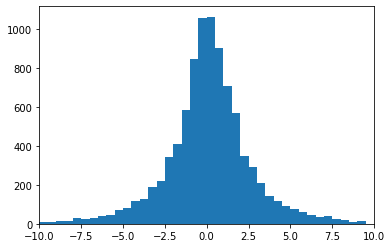

In [143]:
import matplotlib.pyplot as plt

bins = np.arange(-10,10,0.5)
plt.hist(df['ROC_prediction'],bins=bins);
plt.xlim((-10, 10))

In [ ]:
bins = np.arange(-10,10,0.5)#[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
df['ROC_prediction'].value_counts(bins=bins, sort=False) 

In [144]:
#labeling Bullish, Neutral, Bearish

for i in range(len(df['ROC_prediction'])):  
  if df['ROC_prediction'].iloc[i] >= 0.5:
    df['ROC_prediction'].iloc[i] = 'Bullish'
  elif df['ROC_prediction'].iloc[i] >= -0.5:
    df['ROC_prediction'].iloc[i] = 'Neutral'
  else:
    df['ROC_prediction'].iloc[i] = 'Bearish'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [145]:
df['ROC_prediction'].head(10)

Date
2017-01-04    Neutral
2017-01-04    Bearish
2017-01-04    Bearish
2017-01-04    Bullish
2017-01-05    Bullish
2017-01-05    Bullish
2017-01-05    Neutral
2017-01-05    Bullish
2017-01-06    Bullish
2017-01-06    Bullish
Name: ROC_prediction, dtype: object

In [102]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
import keras
from tqdm import tqdm
import pickle
from keras.models import Model
import keras.backend as K
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import itertools
from keras.models import load_model
from sklearn.utils import shuffle
#from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig

In [5]:
# save and reload csv file

#df.to_csv('/content/drive/My Drive/project1/df_test.csv')
df = pd.read_csv('/content/drive/My Drive/project1/df_test.csv',index_col=[0]) 

drop_index=[]
for i in range(len(df)):
  if df['text'].iloc[i] == '[]':
    drop_index.append(df.index[i])
df = df.drop(drop_index)
df = df.dropna()

In [6]:
df.head()

,text,symbol,Open,High,Low,Close,ROC,ROC_prediction,VIX
Date,,,,,,,,,
2017-01-04,"['target-stock.', 'target-stock is the leader ...",TSLA,0.008061,0.009671,0.009050,0.011383,4.608295,Neutral,11.85
2017-01-04,['Why is everyone so confident in target-stock...,NVDA,0.012558,0.013607,0.010804,0.014647,2.333105,Bearish,11.85
2017-01-04,['Why is everyone so confident in NVDA and tar...,AMD,0.026704,0.019566,0.025109,0.021660,0.000000,Bearish,11.85
2017-01-04,['target-stock is interesting to watch this we...,NFLX,0.000000,0.000000,0.000000,0.000503,1.506000,Bullish,11.85
2017-01-05,"['Might sell Tsla got in at 188.', 'When looki...",TSLA,0.010851,0.009554,0.010906,0.011324,-0.110132,Bullish,11.67


In [12]:
df['ROC_prediction'].value_counts()

Bullish    3799
Bearish    3267
Neutral    2118
Name: ROC_prediction, dtype: int64

In [216]:
#one hot encoding for 'symbol'
symbol = pd.get_dummies(df.symbol)

In [217]:
df = pd.concat([df, symbol], axis=1)

#label encoding for 'ROC_prediction'
df['ROC_prediction_label'] = df['ROC_prediction'].map({'Neutral':1,'Bearish':0,'Bullish':2})
df = df.drop(columns=['symbol','ROC_prediction','ROC'])

In [218]:
df.head(10)

,text,Open,High,Low,Close,VIX,AAL,AAPL,AMD,AMZN,CCL,GOOG,GOOGL,INTC,JNJ,NFLX,NVDA,TSLA,TWTR,ROC_prediction_label
Date,,,,,,,,,,,,,,,,,,,,
2017-01-04,"['target-stock.', 'target-stock is the leader ...",0.008061,0.009671,0.009050,0.011383,11.85,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2017-01-04,['Why is everyone so confident in target-stock...,0.012558,0.013607,0.010804,0.014647,11.85,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2017-01-04,['Why is everyone so confident in NVDA and tar...,0.026704,0.019566,0.025109,0.021660,11.85,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-01-04,['target-stock is interesting to watch this we...,0.000000,0.000000,0.000000,0.000503,11.85,0,0,0,0,0,0,0,0,0,1,0,0,0,2
2017-01-05,"['Might sell Tsla got in at 188.', 'When looki...",0.010851,0.009554,0.010906,0.011324,11.67,0,0,0,0,0,0,0,0,0,0,0,1,0,2
2017-01-05,['Yeah I bought a load of shares right before ...,0.026479,0.021467,0.025109,0.019494,11.67,0,0,1,0,0,0,0,0,0,0,0,0,0,2
2017-01-05,['[$15.05 revenue per share](http://finance.ya...,0.040973,0.043321,0.044021,0.044303,11.67,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2017-01-05,"['Strikes for the amzn puts?', ""All the report...",0.000000,0.000000,0.000000,0.000000,11.67,0,0,0,1,0,0,0,0,0,0,0,0,0,2
2017-01-06,"[""This post inspired me! Had 10C's typed up f...",0.011623,0.011556,0.010244,0.012524,11.32,0,0,0,0,0,0,0,0,0,0,1,0,0,2


In [219]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [220]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def clean_stopwords_shortwords(w):
    stopwords_list=stopwords.words('english')
    words = w.split() 
    clean_words = [word for word in words if (word not in stopwords_list) and len(word) > 2]
    return " ".join(clean_words) 

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w=clean_stopwords_shortwords(w)
    w=re.sub(r'@\w+', '',w)
    return w

In [221]:
#preprocess a text
df['text']=df['text'].map(preprocess_sentence)    

In [224]:
df.head()
#df.to_csv('/content/drive/My Drive/project1/df_test2.csv')

,text,Open,High,Low,Close,VIX,AAL,AAPL,AMD,AMZN,CCL,GOOG,GOOGL,INTC,JNJ,NFLX,NVDA,TSLA,TWTR,ROC_prediction_label
Date,,,,,,,,,,,,,,,,,,,,
2017-01-04,target stock target stock leader self driving ...,0.008061,0.009671,0.009050,0.011383,11.85,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2017-01-04,everyone confident target stock amd really tra...,0.012558,0.013607,0.010804,0.014647,11.85,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2017-01-04,everyone confident nvda target stock target st...,0.026704,0.019566,0.025109,0.021660,11.85,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2017-01-04,target stock interesting watch week think quar...,0.000000,0.000000,0.000000,0.000503,11.85,0,0,0,0,0,0,0,0,0,1,0,0,0,2
2017-01-05,might sell tsla got looking last years data tr...,0.010851,0.009554,0.010906,0.011324,11.67,0,0,0,0,0,0,0,0,0,0,0,1,0,2


In [159]:
sentences=df['text']
labels=df['ROC_prediction_label']
len(sentences),len(labels)

(9184, 9184)

In [156]:
from transformers import TFBertForSequenceClassification, TFBertForMultipleChoice
from transformers import BertTokenizer, TFBertModel, BertConfig
bert_tokenizer = BertTokenizer.from_pretrained("bert-large-uncased")
#bert_model = TFBertForMultipleChoice.from_pretrained('bert-large-uncased')# 3 나중에 수정

In [160]:
input_ids=[]
attention_masks=[]

#tokenizing
for sent in sentences:
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =512,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [161]:
len(input_ids),len(attention_masks),len(labels)

(9184, 9184, 9184)

In [162]:
log_dir='tensorboard_data/tb_bert'
model_save_path='/content/drive/My Drive/project1/bert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

In [ ]:
#Construct BERT embedding layer

transformer_model = TFBertModel.from_pretrained('bert-base-uncased')

input_ids_1 = tf.keras.layers.Input(shape=(512,), name='input_token', dtype='int32')
input_masks_ids_1 = tf.keras.layers.Input(shape=(512,), name='masked_token', dtype='int32')
X = transformer_model(input_ids_1, input_masks_ids_1)[0]
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(5, activation = 'relu')(X)
#X = tf.keras.layers.Dense(1, activation='relu')(X) # for concatenation, output dim's shoud be '1'
X = tf.keras.layers.Reshape((20,128))(X)
model = tf.keras.Model(inputs=[input_ids_1, input_masks_ids_1], outputs = X)
model.summary()

In [172]:
#model for lstm
#get a stock data
numbers = df[df.columns[1:-1]]
numbers

,Open,High,Low,Close,VIX,AAL,AAPL,AMD,AMZN,CCL,GOOG,GOOGL,INTC,JNJ,NFLX,NVDA,TSLA,TWTR
Date,,,,,,,,,,,,,,,,,,
2017-01-04,0.008061,0.009671,0.009050,0.011383,11.850000,0,0,0,0,0,0,0,0,0,0,0,1,0
2017-01-04,0.012558,0.013607,0.010804,0.014647,11.850000,0,0,0,0,0,0,0,0,0,0,1,0,0
2017-01-04,0.026704,0.019566,0.025109,0.021660,11.850000,0,0,1,0,0,0,0,0,0,0,0,0,0
2017-01-04,0.000000,0.000000,0.000000,0.000503,11.850000,0,0,0,0,0,0,0,0,0,1,0,0,0
2017-01-05,0.010851,0.009554,0.010906,0.011324,11.670000,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-03,0.339861,0.332454,0.338624,0.322640,18.040001,1,0,0,0,0,0,0,0,0,0,0,0,0
2021-06-03,0.391106,0.384888,0.381815,0.384681,18.040001,0,0,0,0,1,0,0,0,0,0,0,0,0
2021-06-03,0.836041,0.831019,0.845417,0.836135,18.040001,0,1,0,0,0,0,0,0,0,0,0,0,0


In [173]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(numbers)

In [ ]:
training_set_scaled

In [197]:
training_set_scaled.shape

(9184, 18)

In [ ]:
labels.shape

In [200]:
#time steps is 20 for LSTM

X_train = []
y_train = []
for i in range(20, 9184): #
    X_train.append(training_set_scaled[i-20:i, 0])
    #y_train.append(labels[i])
X_train= np.array(X_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [201]:
X_train.shape

(9164, 20, 1)

In [178]:
input_ids = input_ids[20:]
labels = labels[20:]
attention_masks = attention_masks[20:]

In [204]:
input_ids.shape, labels.shape, attention_masks.shape, X_train.shape

((9164, 512), (9164,), (9164, 512), (9164, 20, 1))

In [202]:
# Assigned nested Cross validation set

train1_inp, val1_inp = input_ids[:6000], input_ids[6000:7000]
train1_label,val1_label = labels[:6000], labels[6000:7000]
train1_mask,val1_mask = attention_masks[:6000], attention_masks[6000:7000]
train1_stock, val1_stock = X_train[:6000], X_train[6000:7000]

train2_inp, val2_inp = input_ids[:7000], input_ids[7000:8000]
train2_label,val2_label = labels[:7000], labels[7000:8000]
train2_mask,val2_mask = attention_masks[:7000], attention_masks[7000:8000]
train2_stock, val2_stock = X_train[:7000], X_train[7000:8000]

train3_inp, val3_inp = input_ids[:8000], input_ids[8000:9000]
train3_label,val3_label = labels[:8000], labels[8000:9000]
train3_mask,val3_mask = attention_masks[:8000], attention_masks[8000:9000]
train3_stock, val3_stock = X_train[:8000], X_train[8000:9000]

In [203]:
train1_stock.shape

(6000, 20, 1)

In [182]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [184]:
#construct LSTM layer

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, InputLayer
from keras.models import Model
from tensorflow.keras import layers


#Concatenate Market data input and text data input
stock_input = tf.keras.Input(shape=(X_train.shape[1],1),name = 'temp')
concatenated = tf.keras.layers.concatenate([X,stock_input], axis=-1)

#LSTM layer
X2 = LSTM(50, return_sequences = True, dropout=0.2)(concatenated)
X2 = LSTM(50, return_sequences = True,dropout=0.2)(X2)
X2 = LSTM(50, return_sequences = True,dropout=0.2)(X2)
X2 = LSTM(50, return_sequences = True,dropout=0.2)(X2)
X2 = Dense(units = 1,activation = 'softmax')(X2)

model2 = Model([input_ids_1, input_masks_ids_1,stock_input],X2)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 109,582,736
Trainable params: 109,582,736
Non-trainable params: 0
__________________________________________________________________________________________________


In [ ]:
# X2 = regressor
# X2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 20, 50)            10400     
_________________________________________________________________
module_wrapper_8 (ModuleWrap (None, 20, 50)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 20, 50)            20200     
_________________________________________________________________
module_wrapper_9 (ModuleWrap (None, 20, 50)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 20, 50)            20200     
_________________________________________________________________
module_wrapper_10 (ModuleWra (None, 20, 50)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 50)               

In [187]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

model2.compile(loss=loss,optimizer=optimizer,metrics=[metric])

In [205]:
history=model2.fit([train1_inp,train1_mask,train1_stock],train1_label,batch_size=4,epochs=4,validation_data=([val1_inp,val1_mask,val1_stock],val1_label),callbacks=callbacks)

Epoch 1/4
1500/1500 [==============================] - 284s 173ms/step - loss: 2.9957 - accuracy: 0.3689 - val_loss: 2.9957 - val_accuracy: 0.3492
Epoch 2/4
1500/1500 [==============================] - 254s 170ms/step - loss: 2.9957 - accuracy: 0.3496 - val_loss: 2.9957 - val_accuracy: 0.3500
Epoch 3/4
1500/1500 [==============================] - 255s 170ms/step - loss: 2.9957 - accuracy: 0.3511 - val_loss: 2.9957 - val_accuracy: 0.3503
Epoch 4/4
1500/1500 [==============================] - 255s 170ms/step - loss: 2.9957 - accuracy: 0.3510 - val_loss: 2.9957 - val_accuracy: 0.3504


In [206]:
model_save_path='/content/drive/My Drive/project1/bert_model.h5'

trained_model = model2
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights(model_save_path)

In [208]:
preds = model2.predict([val1_inp,val1_mask,val1_stock],batch_size=32)

In [ ]:
preds

In [210]:
preds[0].shape

(20, 1)

In [213]:
pred_labels = preds.argmax(axis=1)
pred_labels
f1 = f1_score(val1_label,pred_labels,average = None)
print('F1 score',f1)
print('Classification Report')
print(classification_report(val1_label,pred_labels))
print('Training and saving built model.....')

F1 score [0.54227405 0.         0.        ]
Classification Report
              precision    recall  f1-score   support

           0       0.37      1.00      0.54       372
           1       0.00      0.00      0.00       162
           2       0.00      0.00      0.00       466

    accuracy                           0.37      1000
   macro avg       0.12      0.33      0.18      1000
weighted avg       0.14      0.37      0.20      1000

Training and saving built model.....


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [3]:
pip freeze > requirements.txt